# Taxi predction

<img src="https://cdn2.civitatis.com/estados-unidos/nueva-york/guia/taxi.jpg">

## 1. Business Understanding

Este modelo tem como objetivo prever o tempo total de uma corrida de taxi na cidade de Nova York. Para isto, foi utilizada uma base de dados disponibilizada pela NYC Taxi and Limousine Commission. A base pode ser encontrada site Kaggle.

Link para a página do Kaggle: https://www.kaggle.com/c/nyc-taxi-trip-duration

<p> 
    Neste projeto utilizei a metodologia CRISPDM para estruturar a análise.
</p>

### Desenvolvido por Bruno Gabriel de Sousa

## 2. Data Understanding

In [134]:
# Data manipuation
import pandas as pd
import numpy as np
from haversine import haversine
from datetime import datetime, time

# Visualizing
import matplotlib.pyplot as plt

# Model selection and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

#Implemetation
import folium
from OSMPythonTools.nominatim import Nominatim

Importando a base de dados para o pandas a partir de um arquivo CSV.

In [135]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Variáveis envolvidas no projeto: 

<p>ID - Registro único de cada corrida na base de dados.</p>
<p>vendor_id - ID da empresa associada que fez o registro da corrida.</p>
<p>pickup_datetime- Data e horário do início da corrida.</p>
<p>dropoff_datetime - Data e horário do final da corrida.</p>
<p>passenger_count- Número de passageiros em cada corrida.</p>
<p>pickup_longitude - Coordenada de longitude do inicio da corrida.</p>
<p> pickup_latitude - Coordenada de latitude do inicio da corrida.</p>
<p>dropoff_longitude - Coordenada de longitude do final da corrida.</p>
<p>dropoff_latitude - Coordenada de latitude do final da corrida.</p>
<p>store_and_fwd_flag - Indicativo se o taxi estava conectado a internet e enviou as informações da corrida antes de continuar a próxima.</p>
<p>trip_duration - Duração da corrida.</p>

Tipos das variáveis e tamanho da base de dados.

In [136]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Distribuição dos valores em cada coluna da base.

In [137]:
df_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Não há valores nulos ou faltantes em todas as colunas.

In [138]:
df_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Quantidade de valores diferentes em cada variável independente.

In [139]:
print("id - {}".format(df_train['id'].nunique()))
print("vendor_id - {}".format(df_train['vendor_id'].nunique()))
print("pickup_datetime - {}".format(df_train['pickup_datetime'].nunique()))
print("dropoff_datetime - {}".format(df_train['dropoff_datetime'].nunique()))
print("passenger_count - {}".format(df_train['passenger_count'].nunique()))
print("pickup_longitude - {}".format(df_train['pickup_longitude'].nunique()))
print("pickup_latitude - {}".format(df_train['pickup_latitude'].nunique()))
print("dropoff_longitude - {}".format(df_train['dropoff_longitude'].nunique()))
print("dropoff_latitude - {}".format(df_train['dropoff_latitude'].nunique()))
print("store_and_fwd_flag - {}".format(df_train['store_and_fwd_flag'].nunique()))

id - 1458644
vendor_id - 2
pickup_datetime - 1380222
dropoff_datetime - 1380377
passenger_count - 10
pickup_longitude - 23047
pickup_latitude - 45245
dropoff_longitude - 33821
dropoff_latitude - 62519
store_and_fwd_flag - 2


Histograma da variável dependente.

<AxesSubplot:>

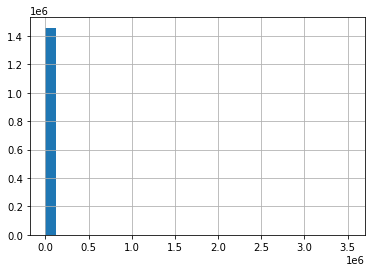

In [140]:
df_train['trip_duration'].hist(bins=30)

Gráfico de boxplot da variável dependente.

{'whiskers': [<matplotlib.lines.Line2D at 0x25a8cb005e0>,
 'caps': [<matplotlib.lines.Line2D at 0x25a8cb00ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x25a8cb00280>],
 'medians': [<matplotlib.lines.Line2D at 0x25a8cb0a3d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x25a8cb0a700>],
 'means': []}

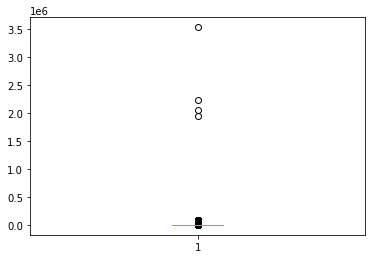

In [141]:
plt.boxplot(df_train['trip_duration'])

Correlação entre as variáveis dependente e independentes.

In [142]:
df_train.corr()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000


## Data Preparation

A variável store_and_fwd_flag possui apenas dois valores distintos no total. 

In [143]:
df_train['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

Olhando um pouco mais de perto, a variável store_and_fwd_flag além de ter poucos valores diferentes também possui uma distribuição muito baixa entre os dados. Como essa variável já é categórica, decidi não utiliza-la para treinar o modelo.

In [144]:
df_train.drop(['store_and_fwd_flag'], axis=1, inplace=True)

In [145]:
df_train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

A variável vendor_id também possui apenas dois valores distintos, mas sua distribuição é bem mais equilibrada entre os dados. Entretanto, a correlação com a variável dependente é baixa. Não há alguma informação explícita na documentação da base de dados que represente cada um dos valores da variável além da breve descrição apresentada anteriormente. Decidi removê-la do treinamento.

In [146]:
df_train.drop(['vendor_id'], axis=1, inplace=True)

É necessário realizar algumas manipulações na variável pickup_datetime. A variável é do tipo string, e como temos um milhão quatrocentos e cinquenta e oito mil seiscentos e quarenta e quatro linhas no dataframe, uma mudança para variável tipo dummy é impraticável pela quantidade de dados. Vou dividir os dados nas seguintes categorias:

00:00 até 05:59 - madrugada.
06:00 até 11:59 - manhã.
12:00 até 17:59 - tarde.
18:00 até 23:59 - noite.

Em relação a variável dropoff_datetime, decidi não utilizá-la pois tem o mesmo sentido que o resultado da previsão do tempo da corrida.

In [147]:
df_train.drop(['dropoff_datetime'], axis=1, inplace=True)

Convertendo horários e datas para períodos do dia na variável pickup_datetime.

In [148]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])

df_temp = df_train.loc[:, ['pickup_datetime']]

df_train.loc[(df_temp['pickup_datetime'].dt.time >= time(0, 0, 0)) & (df_temp['pickup_datetime'].dt.time < time(6, 0, 0)), 'pickup_datetime'] = 'madrugada'
df_train.loc[(df_temp['pickup_datetime'].dt.time >= time(6, 0, 0)) & (df_temp['pickup_datetime'].dt.time < time(12, 0, 0)), 'pickup_datetime'] = 'manha'
df_train.loc[(df_temp['pickup_datetime'].dt.time >= time(12, 0, 0)) & (df_temp['pickup_datetime'].dt.time < time(18, 0, 0)), 'pickup_datetime'] = 'tarde'
df_train.loc[(df_temp['pickup_datetime'].dt.time >= time(18, 0, 0)) & (df_temp['pickup_datetime'].dt.time <= time(23, 59, 59)), 'pickup_datetime'] = 'noite'

Transformando os dados da coluna pickup_datetime para variáveis dummy.

In [149]:
df_train = pd.get_dummies(df_train, columns=['pickup_datetime'])

Temos no dataset quatro variáveis de coordenadas geográficas. Com base nessas variáveis conseguimos obter uma distância aproximada da corrida. Isso é interessante para tentar criar uma correlação maior com a variável dependente trip_duration. Como este é um projeto experimental, vou utilizar a distância de haversine. Essa distância seria uma linha reta entre dois pontos no globo terrestre. Não utilizei bibliotecas como a do Google Maps devido a cobrança por requests ou por baixo desempenho de bibliotecas gratuitas para a quantidade de dados na base.

Convertendo as coordenadas geográficas para distância em quilômetros.

In [150]:
quilometragem = df_train.apply(
                                    lambda row: round(haversine((row['pickup_latitude'], row['pickup_longitude']),
                                                        (row['dropoff_latitude'],row['dropoff_longitude'])), 1),
                                    axis=1
                                )

df_train['quilometragem'] = kilometragem

As colunas abaixo foram transformadas para a nova coluna quilometragem. Não será mais necessário utilizá-las.

In [151]:
df_train.drop(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], axis=1, inplace=True)

Como ficou a distribuição dos dados após a transformação das variáveis de coordenada geográfica.

In [152]:
df_train['quilometragem'].describe()

count    1.458644e+06
mean     3.440831e+00
std      4.296641e+00
min      0.000000e+00
25%      1.200000e+00
50%      2.100000e+00
75%      3.900000e+00
max      1.240900e+03
Name: quilometragem, dtype: float64

In [153]:
df_train[df_train['quilometragem'] == 0]

,id,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,quilometragem
246,id3487442,1,227,0,0,1,0,0.0
291,id0924324,2,1109,0,0,1,0,0.0
323,id2954399,1,40,0,1,0,0,0.0
337,id0790613,1,1778,0,0,0,1,0.0
407,id1145809,6,947,0,0,1,0,0.0
...,...,...,...,...,...,...,...,...
1457746,id1044471,1,12,0,0,1,0,0.0
1458044,id3200588,1,7,1,0,0,0,0.0
1458291,id0078326,1,318,1,0,0,0,0.0
1458544,id3958653,1,38,0,0,0,1,0.0


Após a transformação para a variável quilometragem, alguns valores ficaram zerados. Não é interessante para este algoritmo aprender valores zerados de distância. Abaixo será realizado a limpeza destes dados.

In [154]:
filtered_km = df_train.query('quilometragem == 0')
df_train.drop(filtered_km.index, inplace=True)

Como ficou o dataframe após as transformações.

In [155]:
df_train.head()

,id,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,quilometragem
0,id2875421,1,455,0,0,0,1,1.5
1,id2377394,1,663,1,0,0,0,1.8
2,id3858529,1,2124,0,1,0,0,6.4
3,id3504673,1,429,0,0,1,0,1.5
4,id2181028,1,435,0,0,0,1,1.2


In [156]:
df_train.corr()

,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,quilometragem
passenger_count,1.000000,0.008408,0.007668,-0.019891,0.008741,0.004255,0.009857
trip_duration,0.008408,1.000000,-0.003691,-0.005448,-0.003858,0.011759,0.094625
pickup_datetime_madrugada,0.007668,-0.003691,1.000000,-0.207748,-0.263188,-0.235765,0.063879
pickup_datetime_manha,-0.019891,-0.005448,-0.207748,1.000000,-0.411428,-0.368560,-0.036549
pickup_datetime_noite,0.008741,-0.003858,-0.263188,-0.411428,1.000000,-0.466914,0.006950
pickup_datetime_tarde,0.004255,0.011759,-0.235765,-0.368560,-0.466914,1.000000,-0.017831
quilometragem,0.009857,0.094625,0.063879,-0.036549,0.006950,-0.017831,1.000000


Com as transformações que realizamos ainda não conseguimos atingir uma correlação interessante entre as variáveis. Entretanto, existem diversos outliers na variável trip_duration (variável dependente). Isso pode estar atrapalhando a correlação entre as variáveis. Abaixo será realizada a limpeza dos dados outliers desta variável utilizando o método IQR (Inter Quartile Range)

In [157]:
Q1 = df_train['trip_duration'].quantile(0.25)
Q3 = df_train['trip_duration'].quantile(0.75)
IQR = Q3 - Q1

filtered = df_train.query('(@Q1 - 1.5 * @IQR) < trip_duration > (@Q3 + 1.5 * @IQR)')
df_train.drop(filtered.index, inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x25a89fccb80>,
 'caps': [<matplotlib.lines.Line2D at 0x25a89fbf910>,
 'boxes': [<matplotlib.lines.Line2D at 0x25a89fb8c70>],
 'medians': [<matplotlib.lines.Line2D at 0x25a89ff5f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x25a89f55310>],
 'means': []}

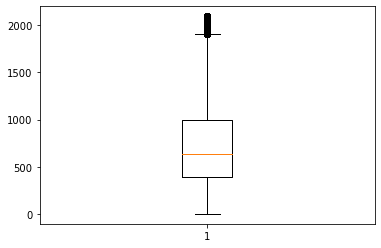

In [158]:
plt.boxplot(df_train['trip_duration'])

<AxesSubplot:>

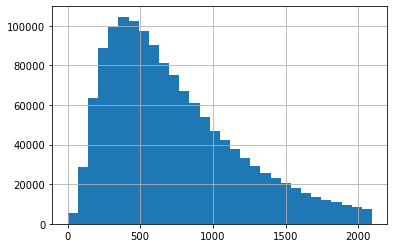

In [159]:
df_train['trip_duration'].hist(bins=30)

A distribuição dos valores e a distância entre os outliers e o máximo do gráfico de boxplot melhorou consideravelmente após a limpeza dos dados na variável trip_duration.

In [160]:
df_train.corr()

,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,quilometragem
passenger_count,1.000000,0.010363,0.008290,-0.020174,0.009423,0.003314,0.004923
trip_duration,0.010363,1.000000,-0.025750,-0.018342,-0.002006,0.038156,0.601224
pickup_datetime_madrugada,0.008290,-0.025750,1.000000,-0.211666,-0.270378,-0.234762,0.122473
pickup_datetime_manha,-0.020174,-0.018342,-0.211666,1.000000,-0.416308,-0.361468,-0.038761
pickup_datetime_noite,0.009423,-0.002006,-0.270378,-0.416308,1.000000,-0.461732,0.033516
pickup_datetime_tarde,0.003314,0.038156,-0.234762,-0.361468,-0.461732,1.000000,-0.086705
quilometragem,0.004923,0.601224,0.122473,-0.038761,0.033516,-0.086705,1.000000


Com a retirada dos outliers, podemos ver que a correlação de algumas variáveis respondeu muito melhor com a limpeza dos dados. A variável quilometragem foi a que respondeu melhor.

{'whiskers': [<matplotlib.lines.Line2D at 0x25a8ccbf370>,
 'caps': [<matplotlib.lines.Line2D at 0x25a8ccbfa30>,
 'boxes': [<matplotlib.lines.Line2D at 0x25a8ccb1fd0>],
 'medians': [<matplotlib.lines.Line2D at 0x25a8ccc9130>],
 'fliers': [<matplotlib.lines.Line2D at 0x25a8ccc9490>],
 'means': []}

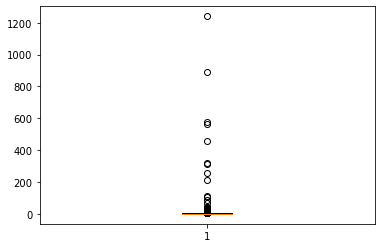

In [161]:
plt.boxplot(df_train['quilometragem'])

<AxesSubplot:>

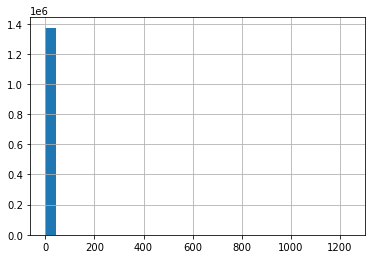

In [162]:
df_train['quilometragem'].hist(bins=30)

A variável quilometragem também tem vários outliers. Abaixo será utilizada a mesma técnica utilizada na variável trip_duration para limpar os dados.

In [163]:
Q1 = df_train['quilometragem'].quantile(0.25)
Q3 = df_train['quilometragem'].quantile(0.75)
IQR = Q3 - Q1

filtered_km = df_train.query('(@Q1 - 1.5 * @IQR) < quilometragem > (@Q3 + 1.5 * @IQR)')
df_train.drop(filtered_km.index, inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x25a92f63640>,
 'caps': [<matplotlib.lines.Line2D at 0x25a92f63d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x25a92f632e0>],
 'medians': [<matplotlib.lines.Line2D at 0x25a92f6e400>],
 'fliers': [<matplotlib.lines.Line2D at 0x25a92f6e760>],
 'means': []}

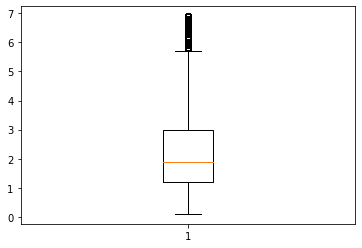

In [164]:
plt.boxplot(df_train['quilometragem'])

<AxesSubplot:>

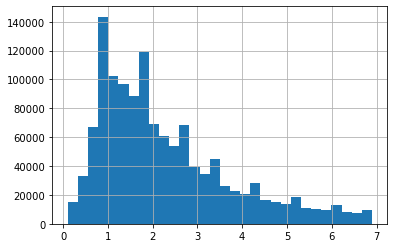

In [165]:
df_train['quilometragem'].hist(bins=30)

In [166]:
df_train.corr()

,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,quilometragem
passenger_count,1.000000,0.009909,0.008597,-0.021053,0.010043,0.003604,0.004316
trip_duration,0.009909,1.000000,-0.083062,-0.005324,-0.012685,0.075243,0.682482
pickup_datetime_madrugada,0.008597,-0.083062,1.000000,-0.202642,-0.255325,-0.227570,0.095078
pickup_datetime_manha,-0.021053,-0.005324,-0.202642,1.000000,-0.418630,-0.373124,-0.045445
pickup_datetime_noite,0.010043,-0.012685,-0.255325,-0.418630,1.000000,-0.470128,0.054297
pickup_datetime_tarde,0.003604,0.075243,-0.227570,-0.373124,-0.470128,1.000000,-0.078706
quilometragem,0.004316,0.682482,0.095078,-0.045445,0.054297,-0.078706,1.000000


A correlação entre as variáveis trip_duration e quilometragem aumentaram 68% com a limpeza dos dados.

Abaixo temos alguns dados da variável passenger_count.

<AxesSubplot:>

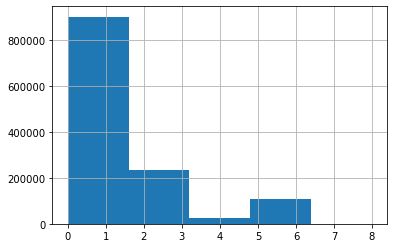

In [167]:
df_train['passenger_count'].hist(bins=5)

{'whiskers': [<matplotlib.lines.Line2D at 0x25a94f0e550>,
 'caps': [<matplotlib.lines.Line2D at 0x25a94f0ec10>,
 'boxes': [<matplotlib.lines.Line2D at 0x25a94f0e1f0>],
 'medians': [<matplotlib.lines.Line2D at 0x25a94f1a310>],
 'fliers': [<matplotlib.lines.Line2D at 0x25a94f1a670>],
 'means': []}

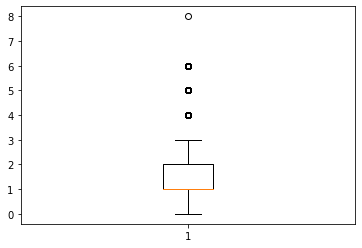

In [168]:
plt.boxplot(df_train['passenger_count'])

Esta variável também possui vários outliers. Abaixo será aplicado a limpeza dos dados.

In [169]:
Q1 = df_train['passenger_count'].quantile(0.25)
Q3 = df_train['passenger_count'].quantile(0.75)
IQR = Q3 - Q1

filtered_passenger_count = df_train.query('(@Q1 - 1.5 * @IQR) < passenger_count > (@Q3 + 1.5 * @IQR)')
df_train.drop(filtered_passenger_count.index, inplace=True)

<AxesSubplot:>

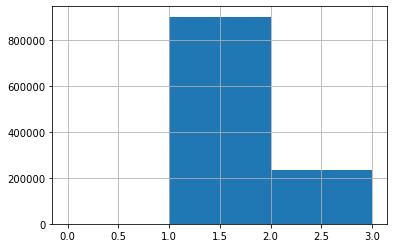

In [170]:
df_train['passenger_count'].hist(bins=3)

{'whiskers': [<matplotlib.lines.Line2D at 0x25aa7a42670>,
 'caps': [<matplotlib.lines.Line2D at 0x25aa7a42d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x25aa7a42310>],
 'medians': [<matplotlib.lines.Line2D at 0x25aa7c21430>],
 'fliers': [<matplotlib.lines.Line2D at 0x25aa7c21790>],
 'means': []}

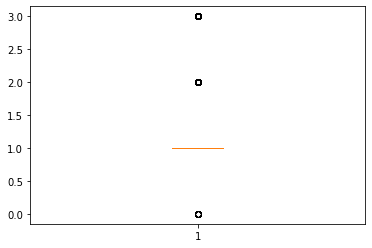

In [171]:
plt.boxplot(df_train['passenger_count'])

Removendo valores onde o número de passageiros é 0.

In [172]:
filtered_passenger_count = df_train.query('passenger_count == 0')
df_train.drop(filtered_passenger_count.index, inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x25aa7c6ae80>,
 'caps': [<matplotlib.lines.Line2D at 0x25aa7c78580>,
 'boxes': [<matplotlib.lines.Line2D at 0x25aa7c6ab20>],
 'medians': [<matplotlib.lines.Line2D at 0x25aa7c78c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x25aa7c78fa0>],
 'means': []}

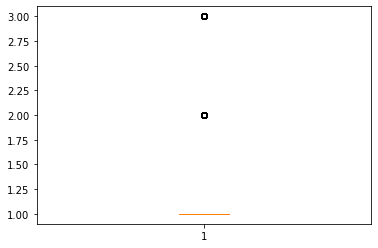

In [173]:
plt.boxplot(df_train['passenger_count'])

In [174]:
df_train.corr()

,passenger_count,trip_duration,pickup_datetime_madrugada,pickup_datetime_manha,pickup_datetime_noite,pickup_datetime_tarde,quilometragem
passenger_count,1.000000,0.021838,0.017938,-0.055688,0.033456,0.005712,0.013074
trip_duration,0.021838,1.000000,-0.083072,-0.005461,-0.012274,0.074883,0.682727
pickup_datetime_madrugada,0.017938,-0.083072,1.000000,-0.202617,-0.254776,-0.227039,0.095611
pickup_datetime_manha,-0.055688,-0.005461,-0.202617,1.000000,-0.419271,-0.373625,-0.045638
pickup_datetime_noite,0.033456,-0.012274,-0.254776,-0.419271,1.000000,-0.469806,0.054897
pickup_datetime_tarde,0.005712,0.074883,-0.227039,-0.373625,-0.469806,1.000000,-0.079387
quilometragem,0.013074,0.682727,0.095611,-0.045638,0.054897,-0.079387,1.000000


A variável passenger_count não possuía uma correlação boa com a variável independente. Mesmo retirando os outliers como feito em outras variáveis, não ajudou muito a aumentar a correlação entre as elas.

## 4 Modeling

Para realizar o processo de treinamento e previsão dos dados, escolhi o método de Regressão Linear. Sendo a variável trip_duration contínua e tendo uma correlação boa entre a variável quilometragem e trip_duration, é propício a utilização deste método para realizar as previsões.

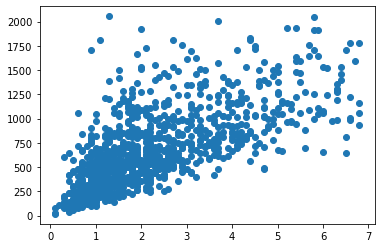

In [175]:
plt.scatter(x=df_train['quilometragem'].tail(1000), y=df_train['trip_duration'].tail(1000))

Variável dependente.

In [176]:
y = df_train['trip_duration']

Variável independente.

In [177]:
X = df_train.loc[:, ['quilometragem']]

In [178]:
model = LinearRegression()

Abaixo será realizada a divisão da base de dados entre treino e teste, o treinamento do algoritmo e também a avaliação utilizando o método MAE (Mean Absolute Error).

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model.fit(X_train, y_train)

y_predicted = model.predict(X_test)

mae(y_predicted, y_test)

219.28615523230565

Com os dados que tinhamos para a previsão, alcançamos um valor de erro de 218 segundos entre a linha de regressão e os dados reais.

## Evaluation

Abaixo será computada uma amostra de mil treinamentos e testes da base de dados. Posteriormente, um gráfico é exibido demonstrando o desempenho do algoritmo em cada processo de treino e teste.

In [180]:
list_x = []
list_y = []
for x in range(1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    list_y.append(mae(y_predicted, y_test))
    list_x.append(x)

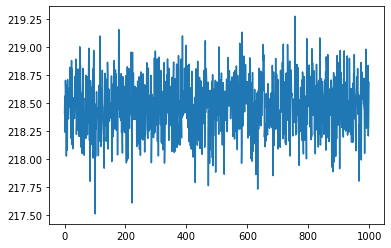

In [181]:
plt.plot(list_x, list_y)

## Aplicando o modelo

Abaixo desenvolvi uma aplicação simples para demonstrar o que foi feito no modelo anteriormente. Você deve entrar com as localizações de origem e destino e o algoritmo dá uma previsão do tempo que a corrida irá levar. Para a demonstração do mapa, foi utilizado a biblioteca OSMPythonTools que utiliza o Open Street Map como fonte de consulta.

In [182]:
nominatim = Nominatim()
input_dados = True
while(input_dados):
  print('---Digite as informações de origem e destino.---')
  print('Os dados devem seguir a seguinte ordem. Rua, número, bairro, cidade, estado, país. \n')

  origin = input("Digite o local de origem: \n")
  print('\n')
  destination = input("Digite o local de destino: \n")
  print('\n')

  #pegando coordenadas de origem
  origin_coordiantes = nominatim.query(origin)
  origin_coordiantes = origin_coordiantes.toJSON()

  #pegando coordenadas de destino
  destination_coordiantes = nominatim.query(destination)
  destination_coordiantes = destination_coordiantes.toJSON()

  if len(origin_coordiantes) == 0:
    print("Dados de origem não encontrados, digite novamente \n")
  elif len(destination_coordiantes) == 0:
    print("Dados de destino não encontrados, digite novamente \n")
  else:
    input_dados = False

---Digite as informações de origem e destino.---
Os dados devem seguir a seguinte ordem. Rua, número, bairro, cidade, estado, país. 

Digite o local de origem: 
West 50th Street, Theater District, Manhattan, New York County, Nova Iorque, 10019, Estados Unidos da América


Digite o local de destino: 
Central Park South, Manhattan Community Board 5, Manhattan, New York County, Nova Iorque, 10019, Estados Unidos da América


[nominatim] downloading data: search


[nominatim] downloading data: search


In [183]:
distance = round(haversine((float(origin_coordiantes[0]['lat']), float(origin_coordiantes[0]['lon'])),
                            (float(destination_coordiantes[0]['lat']),float(destination_coordiantes[0]['lon']))), 1)
previsao = model.predict([[distance]])

map_corrida = folium.Map(location=[float(origin_coordiantes[0]['lat']), float(origin_coordiantes[0]['lon'])], zoom_start=14)

folium.Marker(location=[float(origin_coordiantes[0]['lat']), float(origin_coordiantes[0]['lon'])], 
              icon=folium.Icon(color='green', icon='glyphicon glyphicon-record'), 
              popup="Origem").add_to(map_corrida)

folium.Marker(location=[float(destination_coordiantes[0]['lat']), float(destination_coordiantes[0]['lon'])], 
              icon=folium.Icon(color='red', icon='glyphicon glyphicon-map-marker'), 
              popup="Destino").add_to(map_corrida)

In [184]:
hora, minuto, segundo, resto = 0,0,0,0
convert_pervisao = int(previsao[0])

if convert_pervisao % 3600 == convert_pervisao:
    hora = 0
else:
    hora = int(convert_pervisao / 3600)

if convert_pervisao % 60 == convert_pervisao:
    minuto = 0
else:
    minuto = int(convert_pervisao / 60)

In [185]:
if hora == 0 and minuto == 1:
    print('Tempo esmtimado é de 1 minuto')
elif hora == 0 and minuto > 1:
    print('Tempo esmtimado é de {} minutos'.format(minuto))
elif hora == 1 and minuto == 1:
        print('Tempo esmtimado é de 1 hora e 1 minuto')
elif hora > 1 and minuto > 1:
    print('Tempo esmtimado é de {} horas e {} minutos'.format(horam,minuto))



map_corrida

Tempo esmtimado é de 6 minutos
